In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print(f'Train shape : {train.shape}')
print(f'Test shape : {test.shape}')

Train shape : (1460, 81)
Test shape : (1459, 80)


In [3]:
# Bring train and test together for pre processing and featur engineering
data = pd.concat([train,test], axis=0)
y_train = train['SalePrice']
data = data.drop(['Id', 'SalePrice'], axis=1)
print(data.shape)

(2919, 79)


In [4]:
#Columns containing most null values
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10))

              Total    Percent
PoolQC         2909  99.657417
MiscFeature    2814  96.402878
Alley          2721  93.216855
Fence          2348  80.438506
FireplaceQu    1420  48.646797
LotFrontage     486  16.649538
GarageYrBlt     159   5.447071
GarageFinish    159   5.447071
GarageQual      159   5.447071
GarageCond      159   5.447071


In [5]:
#Dropping columns with > 5 null values
data.drop((missing_data[missing_data['Total'] > 5]).index, axis=1, inplace=True)
#Sorting columns w.r.t null values
total = data.isnull().sum().sort_values(ascending=False)
total.head(20)

MSZoning        4
Functional      2
BsmtFullBath    2
BsmtHalfBath    2
Utilities       2
BsmtFinSF2      1
Exterior2nd     1
GarageCars      1
GarageArea      1
BsmtFinSF1      1
BsmtUnfSF       1
Exterior1st     1
TotalBsmtSF     1
Electrical      1
SaleType        1
KitchenQual     1
HalfBath        0
FullBath        0
BedroomAbvGr    0
KitchenAbvGr    0
dtype: int64

In [6]:
#Filling the numeric data
numeric_missed = ['BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'BsmtFullBath',
'BsmtHalfBath',
'GarageArea',
'GarageCars']
for feature in numeric_missed:
    #data[feature] = data[feature].fillna(0)
    data[feature] = data[feature].fillna(data[feature].mean())
#Filling the categorical data
categorical_missed = ['Exterior1st',
'Exterior2nd',
'SaleType',
'MSZoning',
'Electrical',
'KitchenQual',
'Functional']
for feature in categorical_missed:
    data[feature] = data[feature].fillna(data[feature].mode()[0])
#Deleting 'Utilities' column
data.drop(['Utilities'], axis=1, inplace=True)


In [7]:
#Top skewed columns
numeric_features = data.dtypes[data.dtypes != 'object'].index
skewed_features = data[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
print(high_skew)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146034
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931343
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425233
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.162484
BsmtUnfSF         0.919508
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.623955
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64


In [8]:
#Transforming skewed columns
for feature in high_skew.index:
    data[feature] = np.log1p(data[feature])

In [9]:
#Converting categorical data to numerical
data = pd.get_dummies(data)
data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,9.042040,7,1.791759,7.602900,2003,6.561031,0.0,5.017280,6.753438,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,9.169623,6,2.197225,7.589336,1976,6.886532,0.0,5.652489,7.141245,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,9.328212,7,1.791759,7.601902,2002,6.188264,0.0,6.075346,6.825460,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,9.164401,7,1.791759,7.557995,1970,5.379897,0.0,6.293419,6.629363,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,9.565284,8,1.791759,7.601402,2000,6.486161,0.0,6.196444,7.044033,...,0,0,0,1,0,0,0,0,1,0


In [10]:
#Dividing data back into train & test
train =data[:len(y_train)]
test = data[len(y_train):]
#Printing thier shapes
print(train.shape, test.shape)

(1460, 218) (1459, 218)


In [11]:
# [CHECKPOINT 5][5 points]
def  feature_normalization(X):
    """
    Normalizes the features in X. returns a normalized version of X where
    the mean value of each feature is 0 and the standard deviation
    is 1. This is often a good preprocessing step to do when working with
    learning algorithms.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n).
    
    Returns
    -------
    X_norm : array_like
        The normalized dataset of shape (m x n).
    
    Instructions
    ------------
    First, for each feature dimension, compute the mean of the feature
    and subtract it from the dataset, storing the mean value in mu. 
    Next, compute the  standard deviation of each feature and divide
    each feature by it's standard deviation, storing the standard deviation 
    in sigma. 
    
    Note that X is a matrix where each column is a feature and each row is
    an example. You needto perform the normalization separately for each feature. 
    
    Hint
    ----
    You might find the 'np.mean' and 'np.std' functions useful.
    """
    mu = []
    sigma = []
    X_norm = np.copy(X)
    
    col_to_remove = []
    for i in range(X_norm.shape[1]):
        mu.append(np.mean(X_norm[:,i]))
        sigma.append(np.std(X_norm[:,i]))
    X_norm = np.delete(X_norm, col_to_remove, axis=1)

    # =========================== YOUR CODE HERE =====================
    for i in range(X_norm.shape[1]):
        if np.std(X_norm[:,i]) != 0:
            X_norm[:,i] = (X_norm[:,i] - np.mean(X_norm[:,i])) / np.std(X_norm[:,i])
        else:
            X_norm[:,i] = (X_norm[:,i] - np.mean(X_norm[:,i])) / 0.01
    
    
    # ================================================================
    return X_norm, mu, sigma

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train,
    y_train,
    test_size=0.33, 
    random_state=101
)
'''#features scaling
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float)) #was np.float

print(X_train)'''
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()

X_train, mu, sigma = feature_normalization(X_train)
X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis=1)
X_test, mu, sigma = feature_normalization(X_test)
X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)


In [13]:
# Keras deep learning model

# Creating a Neural Network Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [14]:
model = Sequential()
features = data.shape[1]

model.add(Dense(features,activation='relu'))
model.add(Dense(features,activation='relu'))
model.add(Dense(features,activation='relu'))
model.add(Dense(features,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

In [15]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.int64)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test, dtype=tf.int64)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int64)

model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=400)
model.summary()

Epoch 1/400
8/8 [==============================] - 1s 21ms/step - loss: 39424204800.0000 - val_loss: 38248484864.0000
Epoch 2/400
8/8 [==============================] - 0s 6ms/step - loss: 39407800320.0000 - val_loss: 38209126400.0000
Epoch 3/400
8/8 [==============================] - 0s 6ms/step - loss: 39315857408.0000 - val_loss: 38020022272.0000
Epoch 4/400
8/8 [==============================] - 0s 6ms/step - loss: 38938255360.0000 - val_loss: 37311156224.0000
Epoch 5/400
8/8 [==============================] - 0s 6ms/step - loss: 37605797888.0000 - val_loss: 35135270912.0000
Epoch 6/400
8/8 [==============================] - 0s 6ms/step - loss: 33930479616.0000 - val_loss: 29688576000.0000
Epoch 7/400
8/8 [==============================] - 0s 7ms/step - loss: 25871800320.0000 - val_loss: 19484522496.0000
Epoch 8/400
8/8 [==============================] - 0s 7ms/step - loss: 14987218944.0000 - val_loss: 9806507008.0000
Epoch 9/400
8/8 [==============================] - 0s 7ms/step -

<AxesSubplot:>

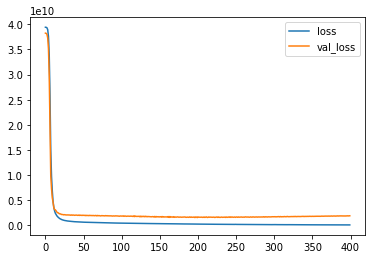

In [16]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

RMSE: 43304.42891545242
VarScore: 0.6927632613562491


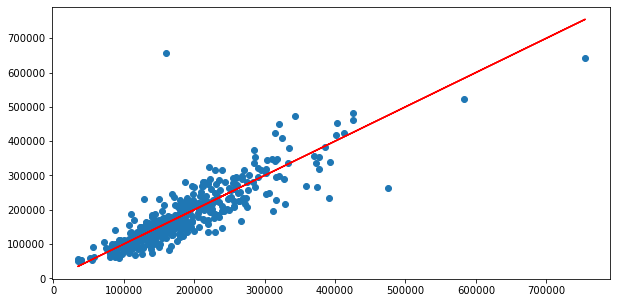

In [20]:
y_pred = model.predict(X_test)
from sklearn import metrics  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
plt.plot(y_test,y_test,'r')


c:\Users\colli\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

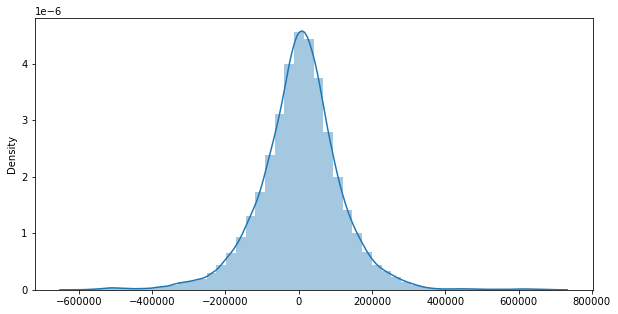

In [18]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test- y_pred)
sns.distplot(residuals)